# Postprocessing data from the reanalysis of the COVID-19 multiomics project

As part of the case study associated with the data found in https://dx.doi.org/10.1101%2F2020.07.17.20156513, we compare the features discovered by the authors and us.

## Summary of our analysis

With our pipeline, we analysed the omics data from the original publication, comparing the severity of COVID-19 states (less severe vs more severe) according to the previously described `HFD-45` metric by the authors. We obtained informative features both within and across the omics data. Then, we compare the features identified from our single-omics analyses, multi-omics analyses, and the authors results.

In [1]:
import os
import re
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import seaborn as sns

In [2]:
# setup all file paths
data_dir = "../../data/case_study_2/"
results_dir = "../../results/case_study_2/"
figures_dir = "../../results/manuscript_figures/"

features_path = "/".join(["../../results/case_study_2/supp_info/", "informative_features.txt"])
unknowns_path = "/".join(["../../results/case_study_2/supp_info/", "putative_unknowns.txt"])
feature_importance_all_path = "/".join(["../../results/case_study_2/supp_info/", "feature_importance_all.txt"])

l_fmap_path = "/".join([data_dir, "lipidomics_featuremap.tsv"]) 
md_fmap_path = "/".join([data_dir, "metabolomicsdiscovery_featuremap.tsv"]) 
mt_fmap_path = "/".join([data_dir, "metabolomicstargeted_featuremap.tsv"]) 
p_fmap_path = "/".join([data_dir, "proteomics_featuremap.tsv"]) 
t_fmap_path = "/".join([data_dir, "transcriptomics_featuremap.tsv"]) 

l_splsda_path = "/".join([results_dir, "lipidome_sPLSDA_max.txt"])
m_splsda_path = "/".join([results_dir, "metabolome_sPLSDA_max.txt"])
p_splsda_path = "/".join([results_dir, "proteome_sPLSDA_max.txt"])
t_splsda_path = "/".join([results_dir, "transcriptome_sPLSDA_max.txt"])

l_diablo_path = "/".join([results_dir, "lipidome_DIABLO_max.txt"])
m_diablo_path = "/".join([results_dir, "metabolome_DIABLO_max.txt"])
p_diablo_path = "/".join([results_dir, "proteome_DIABLO_max.txt"])
t_diablo_path = "/".join([results_dir, "transcriptome_DIABLO_max.txt"])

diablo_path = "/".join([results_dir, "DIABLO_var_keepx_correlations.txt"])

fig_outfile = "".join([figures_dir, "case_2_compare.pdf"])

In [3]:
# load the single omics data
l_splsda = pd.read_csv(l_splsda_path, sep="\t")
m_splsda = pd.read_csv(m_splsda_path, sep="\t")
p_splsda = pd.read_csv(p_splsda_path, sep="\t")
t_splsda = pd.read_csv(t_splsda_path, sep="\t")

# load the multi omics data
l_diablo = pd.read_csv(l_diablo_path, sep="\t")
m_diablo = pd.read_csv(m_diablo_path, sep="\t")
p_diablo = pd.read_csv(p_diablo_path, sep="\t")
t_diablo = pd.read_csv(t_diablo_path, sep="\t")

# load the diablo correlations
diablo = pd.read_csv(diablo_path, sep="\t")

In [4]:
# for technical reasons, we shortened names
# we saved the mappings before running the pipeline, now we remap them
l_fmap = pd.read_csv(l_fmap_path, sep="\t")[["short", "long"]].set_index("short")
md_fmap = pd.read_csv(md_fmap_path, sep="\t")[["short", "long"]].set_index("short")
mt_fmap = pd.read_csv(mt_fmap_path, sep="\t")[["short", "long"]].set_index("short")
p_fmap = pd.read_csv(p_fmap_path, sep="\t")[["short", "long"]].set_index("short")
t_fmap = pd.read_csv(t_fmap_path, sep="\t")[["short", "long"]].set_index("short")
fmap = pd.concat([l_fmap, md_fmap, mt_fmap, p_fmap, t_fmap])
fmap.index.name = None

# R quietly converts non-alphanumeric characters in feature names to "."
# we need to match these changes in order to remap
fmap.index = [re.sub('[^0-9a-zA-Z_]', '.', x) for x in fmap.index]

In [5]:
def remap_identifiers(data, keys):
    data = keys.merge(data, left_index=True, right_index=True, how="right")
    data.set_index("long", inplace=True)
    data.sort_values("importance", inplace=True, ascending=False)
    data.index.name = None
    return data[["GroupContrib", "importance"]]

singleomics = [remap_identifiers(x, fmap) for x in [l_splsda, m_splsda, p_splsda, t_splsda]]
multiomics = [remap_identifiers(x, fmap) for x in [l_diablo, m_diablo, p_diablo, t_diablo]]
[x.shape for x in multiomics]

[(14, 2), (16, 2), (13, 2), (37, 2)]

## Investigate how many of our single omics features match the original data (219 informative features)

In [6]:
def compare_data(old, new):
    return old.merge(new, left_index=True, right_index=True, how="left")

# load in the most informative features identified by the original analysis
features = pd.read_csv(features_path, sep="\t").set_index("standardized_name")
features.index.name = None
features.index = [x.strip() for x in features.index.tolist()]

# investigate how many single omics features match the authors data
# for lipidomics, metabolomics, proteomics, transcriptomics respectively
[compare_data(features, x).importance.nunique() for x in singleomics]

[2, 0, 0, 0]

## Investigate how many of our multi omics features match the original data (219 informative features)

In [7]:
# investigate how many multi omics features match the authors data
# for lipidomics, metabolomics, proteomics, transcriptomics respectively
[compare_data(features, x).importance.nunique() for x in multiomics]

[2, 0, 0, 0]

In [8]:
# reformat the correlation matrix to a more readable format
diablo_flat = diablo.stack().reset_index()
diablo_flat = diablo_flat.merge(fmap, left_on="level_0", right_index=True, how="left")
diablo_flat.drop(["level_0"], axis=1, inplace=True)
diablo_flat = diablo_flat.merge(fmap, left_on="level_1", right_index=True, how="left")
diablo_flat.drop(["level_1"], axis=1, inplace=True)
diablo_flat = diablo_flat[["long_x", "long_y", 0]].sort_values(0, ascending=False)
diablo_flat.columns = ["Feature_1", "Feature_2", "Correlation"]
diablo_flat

,Feature_1,Feature_2,Correlation
5589,PGD,PGD,0.922219
1701,unknown RT 16.698449,unknown RT 16.698449,0.922152
5541,PGD,unknown RT 16.698449,0.919925
1749,unknown RT 16.698449,PGD,0.919925
4617,H6PD,H6PD,0.918531
...,...,...,...
6389,ZNF527,PGD,-0.893038
4639,H6PD,ZNF527,-0.893972
6377,ZNF527,H6PD,-0.893972
6341,ZNF527,unknown RT 16.698449,-0.897951


## Compare our highly correlating multi-omics feature values to original data (219 informative features)

In [9]:
# how many of our highly correlating values match the authors?
feature_list = diablo_flat["Feature_1"].unique()

feat_1 = features.merge(diablo_flat, left_index=True, right_on="Feature_1", how="left")
feat_1 = feat_1[feat_1.Correlation.notnull()]

feat_2 = features.merge(diablo_flat, left_index=True, right_on="Feature_2", how="left")
feat_2 = feat_2[feat_2.Correlation.notnull()]

feat_intersect = pd.concat([feat_1, feat_2]).reset_index().drop("index", axis=1)
feat_intersect.biomolecule_id.nunique()

2

## Find highly +ve/-ve correlations for drug target search (downstream analysis)

In [10]:
# find highly +ve/-ve correlations for drug target search
high_corr = diablo_flat[(diablo_flat.Correlation >= 0.5) | (diablo_flat.Correlation <= -0.5)]
high_features = pd.DataFrame(high_corr[["Feature_1", "Feature_2"]].stack().unique())
outfile_path = "/".join([results_dir, "high_correlated_features.txt"])

# map unknowns to putative unknowns
putative_unknowns = pd.read_csv(unknowns_path, sep="\t", skiprows=1)
putative_unknowns = putative_unknowns[["standardized_name", "Name"]]
high_features = high_features.merge(putative_unknowns, left_on=0, right_on="standardized_name", how="left")
renamed = high_features[high_features.standardized_name.notnull()]
for i in renamed.index:
    high_features.loc[i] = renamed.loc[i]["Name"]
high_features.drop(["standardized_name", "Name"], axis=1, inplace=True)
high_features = high_features[~high_features[0].str.startswith("unknown")]
high_features = high_features[~high_features[0].str.startswith("Unknown")]

# some features are represented as a concatenation of multiple features
high_features = high_features[0].tolist()
high_features = [x.split(";") for x in high_features]
high_features = [x for y in high_features for x in y]
high_features = pd.DataFrame(high_features)
high_features.to_csv(outfile_path, sep="\t", index=None, header=None)
high_features.shape
high_features

,0
0,PGD
1,H6PD
2,C1orf226
3,ZNF527
4,"Quinolinic acid, bis(trimethylsilyl) ester RT1..."
...,...
65,LOC100130520
66,X6R8F3
67,P80188
68,P80188-2


## Compare our highly correlating multi-omics feature values to authors (features ranked by importance in their tree-based classifier)

We show that our highly correlated multi-omics features overlap with highly-scoring features identified by a tree-based classifier in the original analysis. First, we filtered this list by removing all features which were assigned an importance score of 0. Next, we matched the features we discovered through our pipeline to these features found by the original analysis. We find that a subset of 24 features fall above the median score of importance among important features identified in the original analysis. In particular, our pipeline recovers quinolinic acid, which was an important metabolite highlighted in the original study (Overmyer et al., 2020) due to its role in immune function (Heyes et al., 1992; Sofia et al., 2018) and COVID-19 severity (Migaud et al., 2020). Therefore, we show that our pipeline independently recapitulates some of the higher scoring features from an unrelated method which was customised to the experimental context.

Our list of features is comparatively small compared to the full range of feature scores generated by the original study. However, we note that our approach works by selecting subsets of features with cross-validation. When contrasted against the original data, a subset of the most informative features were selected. Furthermore, our generic pipeline is shown to partially recapitulate results obtained from an algorithm which was specifically tailored to the study. Therefore, we demonstrate that our aim of providing an agnostic, flexible pipeline for analysing multi-omics data is met.

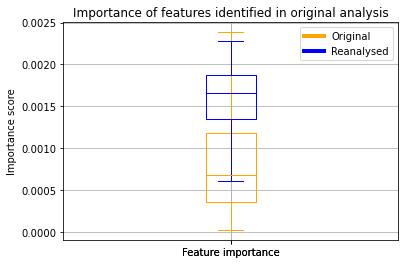

Features with positive importance score in original analysis (of all features)=8.090258668134286 %
Blue = our features: 24 | Orange = authors features: 1176


(24, 2)

In [11]:
# where do our features fall in the spectrum of importance shown by an independent tree-based classifier?
feature_importance_all = pd.read_csv(feature_importance_all_path, sep="\t")
total_features = feature_importance_all["feature importance"].count()

# remove all features with null importance score
feature_importance_all = feature_importance_all[feature_importance_all["feature importance"] > 0]

# some features are composite (eg different isoforms of same protein)
feature_importance_all = pd.DataFrame(pd.concat([pd.Series(row['feature importance'], 
                                                           row['biomolecule'].split(';')) 
                                                for _, row in feature_importance_all.iterrows()]))

# some features we detect overlap with the authors, show distribution
fig, ax = plt.subplots()
feature_importance_all.boxplot(color="orange", ax=ax, showfliers=False)
intersecting_features = high_features.merge(feature_importance_all, left_on=0, right_index=True)
intersecting_features.drop("0_x", axis=1, inplace=True)
intersecting_features.columns = ["index", "Feature importance"]
intersecting_features.boxplot(color="blue", showbox=True, ax=ax, showfliers=False)

plt.title("Importance of features identified in original analysis")
custom_lines = [Line2D([0], [0], color="orange", lw=4),
                Line2D([0], [0], color="blue", lw=4)]
plt.legend(custom_lines, ["Original", "Reanalysed"])
plt.ylabel("Importance score")
plt.savefig(fname=fig_outfile, dpi=300)
plt.show()

percent_important = str((feature_importance_all.count()[0] / total_features) * 100)
print("".join(["Features with positive importance score in original analysis (of all features)=", 
               percent_important,
              " %"]))

axis_title = " ".join(["Blue = our features:", 
                       str(intersecting_features.count()[0]),
                       "| Orange = authors features:",
                       str(feature_importance_all.count()[0]),
                      ])
print(axis_title)

# features that dont have positive importance scores are also interesting
nonintersecting_features = high_features.merge(feature_importance_all, left_on=0, right_index=True, how="outer")
nonintersecting_features = nonintersecting_features[nonintersecting_features["0_y"].isna()]["key_0"]
nonintersecting_features = nonintersecting_features.reset_index().drop("index", axis=1)
intersecting_features.shape

# Notes

The files in the results directory were a concatenation of all features obtained from the analyses. These are available in gitlab in the results directory. To reproduce these files, after running our pipeline navigate to your results directory and run the following commands.

## Authors data

- [Supplementary table 1](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7388490/bin/90133-2020.07.17.20156513-2.xlsx) - enriched pathways in each omics
- [Supplementary table 2](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7388490/bin/90133-2020.07.17.20156513-3.xlsx) - unknown features mapped to putative features
- [Supplementary table 3](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7388490/bin/90133-2020.07.17.20156513-4.xlsx) - 219 informative features
- [Supplementary table 6](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7388490/bin/90133-2020.07.17.20156513-7.xlsx) - feature importances identified by a tree-based classifier

Files were exported from the excel spreadsheets as tab separated lists of values. Unrecognised byte characters and windows line endings were removed. The clean versions of the files in plain text format are available in the gitlab repository.


## Concatenating files to examine features

The pipeline outputs features per individual component. We concatenated all these to get the full feature lists returned by `sPLSDA` and `DIABLO`. These files are available in the git repository under `results/MSV000085703/reformatted_output/`

```
#!/bin/bash
head -n1 lipidome_1_sPLSDA_max.txt > lipidome_sPLSDA_max.txt
for i in lipidome_[0-9]_sPLSDA_max*; do tail -n +2 $i >> lipidome_sPLSDA_max.txt; done
head -n1 metabolome_1_sPLSDA_max.txt > metabolome_sPLSDA_max.txt
for i in metabolome_[0-9]_sPLSDA_max*; do tail -n +2 $i >> metabolome_sPLSDA_max.txt; done
head -n1 proteome_1_sPLSDA_max.txt > proteome_sPLSDA_max.txt
for i in proteome_[0-9]_sPLSDA_max*; do tail -n +2 $i >> proteome_sPLSDA_max.txt; done
head -n1 transcriptome_1_sPLSDA_max.txt > transcriptome_sPLSDA_max.txt
for i in transcriptome_[0-9]_sPLSDA_max*; do tail -n +2 $i >> transcriptome_sPLSDA_max.txt; done

head -n1 lipidome_1_DIABLO_var_keepx_max.txt > lipidome_DIABLO_max.txt
for i in lipidome_[0-9]_DIABLO_var_keepx_max*txt; do tail -n +2 $i >> lipidome_DIABLO_max.txt; done
head -n1 metabolome_1_DIABLO_var_keepx_max.txt > metabolome_DIABLO_max.txt
for i in metabolome_[0-9]_DIABLO_var_keepx_max*txt; do tail -n +2 $i >> metabolome_DIABLO_max.txt; done
head -n1 proteome_1_DIABLO_var_keepx_max.txt > proteome_DIABLO_max.txt
for i in proteome_[0-9]_DIABLO_var_keepx_max*txt; do tail -n +2 $i >> proteome_DIABLO_max.txt; done
head -n1 transcriptome_1_DIABLO_var_keepx_max.txt > transcriptome_DIABLO_max.txt
for i in transcriptome_[0-9]_DIABLO_var_keepx_max*txt; do tail -n +2 $i >> transcriptome_DIABLO_max.txt; done

# md5sum if on linux machine
md5 lipidome_sPLSDA_max.txt metabolome_sPLSDA_max.txt proteome_sPLSDA_max.txt transcriptome_sPLSDA_max.txt \
  lipidome_DIABLO_max.txt metabolome_DIABLO_max.txt proteome_DIABLO_max.txt transcriptome_DIABLO_max.txt

MD5 (lipidome_sPLSDA_max.txt) = 46ad9dde93559c35bf4026184761675b
MD5 (metabolome_sPLSDA_max.txt) = 53001f373a9163a8d1dea70f72546a08
MD5 (proteome_sPLSDA_max.txt) = b336b47e238de50d32e0b3a523e07fd9
MD5 (transcriptome_sPLSDA_max.txt) = 9d704fd469f985c17ac1ce907ce3ec37
MD5 (lipidome_DIABLO_max.txt) = aaba4c96a3fcc77079da1652ae2c5a2d
MD5 (metabolome_DIABLO_max.txt) = cfec4e72698cc3e6b90a5452a6ee4c76
MD5 (proteome_DIABLO_max.txt) = 0b7879b44dc349663e6b2aa6e4ce8732
MD5 (transcriptome_DIABLO_max.txt) = 6c809bc489ffb8ff433de1b0d14bd2bb
```

## Passing results to a drug target search database

```
# put these directly into a drug target search database
wget 'http://unmtid-shinyapps.net/download/drug.target.interaction.tsv.gz'

# some rows have multiple molecules - also note that mostly proteins are in this database
(head -n1 drug.target.interaction.tsv; grep -f ../../results/case_study_2/high_correlated_features.txt drug.target.interaction.tsv | grep -v MOUSE) | tr -d '"' > ../../results/case_study_2/reformatted_output/potential_drugs.txt
```